# Importing modules and defining functions

In [1]:
#Import modules
from matplotlib import pylab as plt
from tqdm import tqdm
import itertools
from joblib import Parallel, delayed, parallel_backend

import pickle
import numpy as np
from numpy.random import RandomState
random_state = RandomState(0)
from sklearn import linear_model
import skcosmo.feature_selection
#from skcosmo.feature_selection import FPS
from skcosmo.sample_selection import PCovCUR, FPS
from skcosmo.preprocessing import StandardFlexibleScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize, callbacks, dump, load
from skopt.callbacks import CheckpointSaver
from skopt.plots import plot_convergence, plot_objective

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
# If installed -- not essential, though
try:
    from tqdm.notebook import tqdm
except ImportError:
    tqdm = (lambda i, **kwargs: i)

from time import time, sleep

from rascal.models import KRR
from rascal.utils import dump_obj, load_obj

from rascal.models import Kernel, train_gap_model, compute_KNM
from rascal.representations import SphericalInvariants
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species
from rascal.representations.spherical_invariants import get_power_spectrum_index_mapping
from rascal.utils import from_dict, to_dict, CURFilter, FPSFilter, dump_obj, load_obj
from rascal.utils import get_score, get_optimal_radial_basis_hypers
from rascal.utils.io import load_json, dump_json

In [2]:
#Define functions
def do_fps(x, d=0):
    """
    Function for performing farthest-point-sampling for a given feature matrix.
    d gives the number of farthest-point-sampled feature vectors that will be outputted. 
    If d==0, the entire set will be FPS-sorted.
    Returns the FPS-sorted IDs, as well as the FPS distances.
    """
    if d == 0 : d = len(x)
    n = len(x)
    iy = np.zeros(d, int)
    # faster evaluation of Euclidean distance
    n2 = np.sum(x**2,axis=1)
    iy[0] = 0
    dl = n2 + n2[iy[0]] - 2* np.dot(x, x[iy[0]])
    dss = []
    for i in range(1,d):
        iy[i] = np.argmax(dl)
        nd = n2 + n2[iy[i]] - 2*np.dot(x,x[iy[i]])
        dl = np.minimum(dl, nd)
        dss.append(max(dl))
    return iy,dss

def get_forces(frames, force_array='PBE-D2_forces'):
    frc = np.zeros((np.sum([len(frm) for frm in frames]),3))
    iat = 0
    for ifrm,frm in enumerate(frames):
        frc[iat:iat+len(frm)] = frm.get_array(force_array) 
        iat += len(frm)
    return frc

def get_features(atoms_objects, batch_size=1000, progress_bar=True):
    '''Get average feature vectors for each structure in a list of atoms objects. 
        This requires soap to be set.
    '''
    struct_feat=[] #create empty feature vector of n_structures x n_features
    got_frame = False
    for frm in atoms_objects:
        if got_frame == False: 
            if all(sp in frm.get_atomic_numbers() for sp in [1,6,7,8]) == True:
                all_species = frm
                got_frame = True
    for i in tqdm(range(int(len(atoms_objects)/batch_size+0.9999)), disable = not progress_bar): #Get feature vectors in batches of 1000
        for frm in atoms_objects[i*batch_size:(i+1)*batch_size]:
            frm.wrap(eps=1e-13) #wrap atoms in unit cell
        frames=[all_species.copy()] #add initial frame with all species
        frames.extend(atoms_objects[i*batch_size:(i+1)*batch_size]) #extend initial frame with frames of batch
        manager = soap.transform(frames) #calculate soap features for all structures in batch
        env_feat_batch = manager.get_features(soap)[len(all_species):] #get feature vectors for all structures in batch
        # (having removed the initial frame)
        atom_counter=0 #count atoms
        for ifrm,frm in enumerate(atoms_objects[i*batch_size:(i+1)*batch_size]): #iterate over frames in batch
            nat=len(frm) #count atoms in frame
            struct_feat.append(np.mean(env_feat_batch[atom_counter:atom_counter+nat],axis=0)) #average vectors
            # for atoms in the same frame. Done by averaging vectors between atom_counter and atom_counter + nat
            atom_counter+=nat #add atoms to counter
    struct_feat_array=np.asarray(struct_feat)
    return struct_feat_array

def get_features_parallel(atoms_objects, bsize=1000, n_cores = 4):
    '''Get average feature vectors for each structure in a list of atoms objects. 
        Do this in parallel
    '''
    blocks = []
    for iblk, blk in enumerate(range(0, len(atoms_objects), bsize)):
        blocks.append(atoms_objects[iblk*bsize:(iblk+1)*bsize])
    with parallel_backend(backend="loky"):
        results = Parallel(n_jobs=n_cores)(delayed(get_features)(frames, batch_size=10000, 
                                                                 progress_bar=False) for frames in blocks)

    return np.concatenate(results)

def predict_batched(frames, ml_model):
    man_pred = soap.transform(frames)
    return ml_model.predict(man_pred)

# Reload database with DFTB+ results

In [3]:
#(Re-)Open dataset
with open('delta_data/CSD-10k_combined_w_kpts_11_pc_w_DFTB.pickle', 'rb') as f:
    db = pickle.load(f)

In [4]:
#Add energy and force deltas to frame
for name in db.keys():
    for frm in db[name]:
        frm.info['Delta_energy'] = frm.info['PBE-D2_energy'] - frm.info['DFTB_energy']
        frm.arrays['Delta_forces'] = frm.arrays['PBE-D2_forces'] - frm.arrays['DFTB_forces']

# Get PCovFPS Sample and Feature IDs

In [5]:
#Reload PCovFPS-sorted sample IDs
pcf_ids = np.load('delta_data/pcovfps_selected_idx.npy')

# Create training and validation sets

In [6]:
#Create training and val sets
all_frames = []
for name in db.keys():
    for frm in db[name]:
        all_frames.append(frm)

ids = np.arange(len(all_frames))
np.random.seed(10)
np.random.shuffle(ids)

train_frames_unsorted = [all_frames[i] for i in ids[1000:]]
val_frames = [all_frames[i] for i in ids[:1000]]

In [7]:
#Sort PCov-FPS sort training IDs
train_frames = [train_frames_unsorted[i] for i in pcf_ids]

In [8]:
#Create composition (X), energy deltas (y) and force deltas (f) arrays
X_all = np.zeros((len(all_frames), 4), dtype=int) ; y_all = np.zeros(len(all_frames), dtype=float)
f_all = np.zeros((np.sum([len(frm) for frm in all_frames]),3), dtype=float)

counter = 0
for ifrm, frm in enumerate(all_frames):
    symbols = frm.get_atomic_numbers()
    X_all[ifrm] = [len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]
    y_all[ifrm] = frm.info['PBE-D2_energy']
    f_all[counter:counter+len(frm)] = frm.arrays['PBE-D2_forces']
    counter += len(frm)
    
X_train = np.zeros((len(train_frames), 4), dtype=int) ; y_train = np.zeros(len(train_frames), dtype=float)
f_train = np.zeros((np.sum([len(frm) for frm in train_frames]),3), dtype=float)

counter = 0
for ifrm, frm in enumerate(train_frames):
    symbols = frm.get_atomic_numbers()
    X_train[ifrm] = [len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]
    y_train[ifrm] = frm.info['PBE-D2_energy']
    f_train[counter:counter+len(frm)] = frm.arrays['PBE-D2_forces']
    counter += len(frm)

X_val = np.zeros((len(val_frames), 4), dtype=int) ; y_val = np.zeros(len(val_frames), dtype=float)
f_val = np.zeros((np.sum([len(frm) for frm in val_frames]),3), dtype=float)

counter = 0
for ifrm, frm in enumerate(val_frames):
    symbols = frm.get_atomic_numbers()
    X_val[ifrm] = [len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]
    y_val[ifrm] = frm.info['PBE-D2_energy']
    f_val[counter:counter+len(frm)] = frm.arrays['PBE-D2_forces']
    counter += len(frm)

In [9]:
#Create baselined per-atom energy model
mlr = Ridge(fit_intercept=False, alpha=1e-4)
mlr.fit(X_all, y_all)
for spec, coef in zip(['H', 'C', 'N', 'O'], mlr.coef_):
    print(f"Per-atom energy for species {spec} : {coef} eV")

Per-atom energy for species H : -16.468153332304215 eV
Per-atom energy for species C : -154.72001091746486 eV
Per-atom energy for species N : -383.34420755813 eV
Per-atom energy for species O : -566.227034198853 eV


In [10]:
#get dressed atom energies for reduced training set
y_dressed = {}
for i,j in enumerate([1,6,7,8]):
    y_dressed[j] = mlr.coef_[i]

# Create test set

In [11]:
#Import test set
with open('raw_data/CSD-1k_hcno_w_DFTB.pickle', 'rb') as f:
    csd_2k = pickle.load(f)
#csd_2k = read('raw_data/CSD-1k_hcno_w_DFTB.pickle', ':')
#Only get CHNO
csd_1k = []
for frm in csd_2k:
    frm.info['Delta_energy'] = frm.info['PBE-D2_energy'] - frm.info['DFTB_energy']
    frm.arrays['Delta_forces'] = frm.arrays['PBE-D2_forces'] - frm.arrays['DFTB_forces']
    good = True
    for elem in np.unique(frm.get_chemical_symbols()):
        if elem not in ['H', 'C', 'N', 'O']:
            good = False
    if good == True:
        csd_1k.append(frm)

In [12]:
#Create composition (X), energy deltas (y) and force deltas (f) arrays
X_test = np.zeros((len(csd_1k), 4), dtype=int) ; y_test = np.zeros(len(csd_1k), dtype=float)
f_test = np.zeros((np.sum([len(frm) for frm in csd_1k]),3), dtype=float)

counter = 0
for ifrm, frm in enumerate(csd_1k):
    symbols = frm.get_atomic_numbers()
    X_test[ifrm] = [len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]
    y_test[ifrm] = frm.info['PBE-D2_energy']
    f_test[counter:counter+len(frm)] = frm.arrays['PBE-D2_forces']
    counter += len(frm)

# Create Model

In [20]:
#Define soap hyperparameters
zeta=3
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=9, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False #don't care about forces right now
              )
soap = SphericalInvariants(**hypers)

In [14]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(train_frames) #calculating features
print("Time taken: ", time()-start, "s")

Computing feature matrices...
Time taken:  491.1472556591034 s


In [31]:
def calculate_sparse_points(ns):
    nsparse    = {1: ns, 6: ns, 7: ns, 8: ns}
    compressor = FPSFilter(soap,nsparse,act_on='sample per species')
    X_sparse = compressor.select_and_filter(manager_train)
    dump_obj(f'learning_curve_data/X_sparse_PCovFPS_{ns}_696.json', X_sparse)

In [39]:
for i in range(500, 4001, 500):
    calculate_sparse_points(i)
    print(f'Calculated sparse points for n_sparse = {i}')

Done for 500
Calculated sparse points for n_sparse = 500
Done for 1000
Calculated sparse points for n_sparse = 1000
Done for 1500
Calculated sparse points for n_sparse = 1500
Done for 2000
Calculated sparse points for n_sparse = 2000
Done for 2500
Calculated sparse points for n_sparse = 2500
Done for 3000
Calculated sparse points for n_sparse = 3000
Done for 3500
Calculated sparse points for n_sparse = 3500
Done for 4000
Calculated sparse points for n_sparse = 4000


In [40]:
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [ ]:
#Compute kernel for all n_sparse
for i in range(500, 4001, 500):
    X_sparse = load_obj(f'learning_curve_data/X_sparse_PCovFPS_{i}_696.json')
    Knm = np.zeros((len(train_frames), X_sparse.get_features().shape[0]), dtype=float)
    start=time()
    for ifrm, frm in enumerate(tqdm(train_frames, desc=f"Computing KNM for n_sparse = {i}", leave=False)):
        feat = soap.transform(frm)
        Knm[ifrm] = kernel(feat, X_sparse)
    np.save(f'learning_curve_data/Knm_learning_curve_{i}', Knm)
    print(f"Knm saved using N sparse = {i}. Time taken :", time()-start, "s")

In [112]:
#Train and test GAP model using various slices of training frames and testing on the first 100 CSD-1k structures
spar_low=500; spar_high=4001; spar_gap=500
ntrain_low=2000; ntrain_high=20001; ntrain_gap=2000

for ni, i in enumerate(range(spar_low, spar_high, spar_gap)):
    K_NM_total = np.load(f'learning_curve_data/Knm_learning_curve_{i}.npy') #import full KNM for this number of sparse points
    X_sparse = load_obj(f'learning_curve_data/X_sparse_PCovFPS_{i}_696.json') #Import X_sparse for this number of sparse points
    results=np.zeros((len(range(ntrain_low, ntrain_high, ntrain_gap)), 2), dtype=float)
    
    for nj, j in enumerate(range(ntrain_low, ntrain_high, ntrain_gap)):
        start = time()
        K_NM = K_NM_total[:j] #get correct slice of KNM
        print(f"Training GAP model using N_sparse={i} and N_train={j}...")
        start = time()
    
        model = train_gap_model(kernel, train_frames[:j], K_NM, X_sparse, y_train[:j], y_dressed, 
                                grad_train=None, lambdas=[0.01], jitter=1e-9, solver = 'RKHS') #train model
        
        #test model on full CSD-1k set (only on first 250 structures)
        npred=250
        ytp = []
        for frm in tqdm(csd_1k[:npred], desc = "Making predictions for test set...", leave=False):
            manager_test = soap.transform(frm)
            ytp.append(model.predict(manager_test))

        y_test_pred = np.array(ytp).flatten()
        rmse = np.sqrt(np.mean(((y_test[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1) 
                               - (y_test_pred[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1))**2))
        
        print(f"RMSE for N_sparse={i} and N_train={j} : {rmse}")
        
        results[nj] = [float(j), rmse]
        np.save(f'learning_curve_data/predictions/0.01_reg/y_test_pred_S{i}_N{j}', y_test_pred)
        
        print("Time taken:", np.round(time()-start, 6), "s")
        print("")
    
    np.save(f'learning_curve_data/rmses/0.01_reg/RMSEs_{i}_sparse_points', results)

Training GAP model using N_sparse=500 and N_train=2000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=500 and N_train=2000 : 0.04474911686521567
Time taken: 57.273845 s

Training GAP model using N_sparse=500 and N_train=4000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=500 and N_train=4000 : 0.017392658552732324
Time taken: 50.98416 s

Training GAP model using N_sparse=500 and N_train=6000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=500 and N_train=6000 : 0.016759043469544214
Time taken: 50.953467 s

Training GAP model using N_sparse=500 and N_train=8000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=500 and N_train=8000 : 0.015998318090743258
Time taken: 46.57688 s

Training GAP model using N_sparse=500 and N_train=10000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=500 and N_train=10000 : 0.015805926824126463
Time taken: 49.834427 s

Training GAP model using N_sparse=500 and N_train=12000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=500 and N_train=12000 : 0.015698847826189487
Time taken: 65.710396 s

Training GAP model using N_sparse=500 and N_train=14000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=500 and N_train=14000 : 0.015904624983398084
Time taken: 52.587997 s

Training GAP model using N_sparse=500 and N_train=16000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=500 and N_train=16000 : 0.01600553059250229
Time taken: 47.743929 s

Training GAP model using N_sparse=500 and N_train=18000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=500 and N_train=18000 : 0.016077700495233112
Time taken: 52.090206 s

Training GAP model using N_sparse=500 and N_train=20000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=500 and N_train=20000 : 0.016052636780244055
Time taken: 51.902212 s

Training GAP model using N_sparse=1000 and N_train=2000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=1000 and N_train=2000 : 0.01884427716415382
Time taken: 93.4545 s

Training GAP model using N_sparse=1000 and N_train=4000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=1000 and N_train=4000 : 0.027200693411847728
Time taken: 93.928015 s

Training GAP model using N_sparse=1000 and N_train=6000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=1000 and N_train=6000 : 0.021386500267007946
Time taken: 95.226659 s

Training GAP model using N_sparse=1000 and N_train=8000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=1000 and N_train=8000 : 0.018118673414529832
Time taken: 97.708845 s

Training GAP model using N_sparse=1000 and N_train=10000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=1000 and N_train=10000 : 0.01694793670002991
Time taken: 94.909727 s

Training GAP model using N_sparse=1000 and N_train=12000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=1000 and N_train=12000 : 0.016372641145092796
Time taken: 95.841299 s

Training GAP model using N_sparse=1000 and N_train=14000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=1000 and N_train=14000 : 0.01615962254754772
Time taken: 97.045477 s

Training GAP model using N_sparse=1000 and N_train=16000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=1000 and N_train=16000 : 0.016271225837308414
Time taken: 95.982339 s

Training GAP model using N_sparse=1000 and N_train=18000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=1000 and N_train=18000 : 0.01623965280282031
Time taken: 97.196959 s

Training GAP model using N_sparse=1000 and N_train=20000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=1000 and N_train=20000 : 0.016307590136595197
Time taken: 96.231286 s

Training GAP model using N_sparse=1500 and N_train=2000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=1500 and N_train=2000 : 0.017051274100795683
Time taken: 151.457138 s

Training GAP model using N_sparse=1500 and N_train=4000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=1500 and N_train=4000 : 0.01929763750302782
Time taken: 146.746012 s

Training GAP model using N_sparse=1500 and N_train=6000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=1500 and N_train=6000 : 0.023520980384212138
Time taken: 153.644325 s

Training GAP model using N_sparse=1500 and N_train=8000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=1500 and N_train=8000 : 0.017065281734567294
Time taken: 167.08891 s

Training GAP model using N_sparse=1500 and N_train=10000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=1500 and N_train=10000 : 0.015763403565158873
Time taken: 181.659422 s

Training GAP model using N_sparse=1500 and N_train=12000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=1500 and N_train=12000 : 0.015233064089835163
Time taken: 157.318789 s

Training GAP model using N_sparse=1500 and N_train=14000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=1500 and N_train=14000 : 0.013942538675610005
Time taken: 163.95337 s

Training GAP model using N_sparse=1500 and N_train=16000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=1500 and N_train=16000 : 0.01374016855207032
Time taken: 158.680254 s

Training GAP model using N_sparse=1500 and N_train=18000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=1500 and N_train=18000 : 0.013907177533089007
Time taken: 154.935242 s

Training GAP model using N_sparse=1500 and N_train=20000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=1500 and N_train=20000 : 0.0139857495890493
Time taken: 169.643443 s

Training GAP model using N_sparse=2000 and N_train=2000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=2000 and N_train=2000 : 0.016160347058798524
Time taken: 211.254875 s

Training GAP model using N_sparse=2000 and N_train=4000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=2000 and N_train=4000 : 0.01822060639846712
Time taken: 206.241188 s

Training GAP model using N_sparse=2000 and N_train=6000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=2000 and N_train=6000 : 0.019006295414358408
Time taken: 211.608876 s

Training GAP model using N_sparse=2000 and N_train=8000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=2000 and N_train=8000 : 0.017872542005953077
Time taken: 205.145809 s

Training GAP model using N_sparse=2000 and N_train=10000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=2000 and N_train=10000 : 0.01698105009890131
Time taken: 204.195159 s

Training GAP model using N_sparse=2000 and N_train=12000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=2000 and N_train=12000 : 0.015963058219578285
Time taken: 208.70991 s

Training GAP model using N_sparse=2000 and N_train=14000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=2000 and N_train=14000 : 0.015052024208715264
Time taken: 210.307071 s

Training GAP model using N_sparse=2000 and N_train=16000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=2000 and N_train=16000 : 0.014785024245317205
Time taken: 247.943376 s

Training GAP model using N_sparse=2000 and N_train=18000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=2000 and N_train=18000 : 0.01446898817593982
Time taken: 223.44241 s

Training GAP model using N_sparse=2000 and N_train=20000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=2000 and N_train=20000 : 0.013754029235336323
Time taken: 217.380264 s

Training GAP model using N_sparse=2500 and N_train=2000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=2500 and N_train=2000 : 0.015596735516599984
Time taken: 266.31238 s

Training GAP model using N_sparse=2500 and N_train=4000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=2500 and N_train=4000 : 0.01710455040073881
Time taken: 325.540094 s

Training GAP model using N_sparse=2500 and N_train=6000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=2500 and N_train=6000 : 0.017827937983194535
Time taken: 277.015832 s

Training GAP model using N_sparse=2500 and N_train=8000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=2500 and N_train=8000 : 0.018188645432757906
Time taken: 275.24958 s

Training GAP model using N_sparse=2500 and N_train=10000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=2500 and N_train=10000 : 0.01745624018583442
Time taken: 284.535 s

Training GAP model using N_sparse=2500 and N_train=12000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=2500 and N_train=12000 : 0.01631023126386724
Time taken: 288.623395 s

Training GAP model using N_sparse=2500 and N_train=14000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=2500 and N_train=14000 : 0.016444405205842852
Time taken: 281.210669 s

Training GAP model using N_sparse=2500 and N_train=16000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=2500 and N_train=16000 : 0.015981427619125004
Time taken: 282.961491 s

Training GAP model using N_sparse=2500 and N_train=18000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=2500 and N_train=18000 : 0.01543334038136208
Time taken: 281.749068 s

Training GAP model using N_sparse=2500 and N_train=20000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=2500 and N_train=20000 : 0.014749884532900317
Time taken: 292.611565 s

Training GAP model using N_sparse=3000 and N_train=2000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=3000 and N_train=2000 : 0.015596157663599675
Time taken: 392.964633 s

Training GAP model using N_sparse=3000 and N_train=4000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=3000 and N_train=4000 : 0.016742557048281415
Time taken: 344.190443 s

Training GAP model using N_sparse=3000 and N_train=6000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=3000 and N_train=6000 : 0.017392994428025946
Time taken: 378.122519 s

Training GAP model using N_sparse=3000 and N_train=8000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=3000 and N_train=8000 : 0.017289780419828482
Time taken: 359.551313 s

Training GAP model using N_sparse=3000 and N_train=10000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=3000 and N_train=10000 : 0.016097370291550447
Time taken: 384.235544 s

Training GAP model using N_sparse=3000 and N_train=12000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=3000 and N_train=12000 : 0.016908451962791116
Time taken: 350.372857 s

Training GAP model using N_sparse=3000 and N_train=14000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=3000 and N_train=14000 : 0.016944146379946706
Time taken: 353.948761 s

Training GAP model using N_sparse=3000 and N_train=16000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=3000 and N_train=16000 : 0.016572547913100956
Time taken: 342.282206 s

Training GAP model using N_sparse=3000 and N_train=18000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=3000 and N_train=18000 : 0.01589348424686457
Time taken: 342.842676 s

Training GAP model using N_sparse=3000 and N_train=20000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=3000 and N_train=20000 : 0.014940915215178555
Time taken: 347.16153 s

Training GAP model using N_sparse=3500 and N_train=2000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=3500 and N_train=2000 : 0.015433690141798226
Time taken: 496.331522 s

Training GAP model using N_sparse=3500 and N_train=4000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=3500 and N_train=4000 : 0.016377917139289537
Time taken: 411.091258 s

Training GAP model using N_sparse=3500 and N_train=6000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=3500 and N_train=6000 : 0.016961417471298073
Time taken: 424.740611 s

Training GAP model using N_sparse=3500 and N_train=8000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=3500 and N_train=8000 : 0.016000404888217728
Time taken: 417.268245 s

Training GAP model using N_sparse=3500 and N_train=10000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=3500 and N_train=10000 : 0.015664873713241968
Time taken: 421.583259 s

Training GAP model using N_sparse=3500 and N_train=12000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=3500 and N_train=12000 : 0.0160718371427035
Time taken: 468.032864 s

Training GAP model using N_sparse=3500 and N_train=14000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=3500 and N_train=14000 : 0.017028342349708847
Time taken: 465.219663 s

Training GAP model using N_sparse=3500 and N_train=16000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=3500 and N_train=16000 : 0.016093239441495478
Time taken: 481.906879 s

Training GAP model using N_sparse=3500 and N_train=18000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=3500 and N_train=18000 : 0.016004132036110792
Time taken: 458.808002 s

Training GAP model using N_sparse=3500 and N_train=20000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=3500 and N_train=20000 : 0.014884261645590199
Time taken: 451.757903 s

Training GAP model using N_sparse=4000 and N_train=2000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=4000 and N_train=2000 : 0.015313045113365151
Time taken: 489.798233 s

Training GAP model using N_sparse=4000 and N_train=4000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=4000 and N_train=4000 : 0.016130453125940157
Time taken: 487.275652 s

Training GAP model using N_sparse=4000 and N_train=6000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=4000 and N_train=6000 : 0.016371860029461633
Time taken: 514.037921 s

Training GAP model using N_sparse=4000 and N_train=8000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=4000 and N_train=8000 : 0.015373172291759218
Time taken: 537.268956 s

Training GAP model using N_sparse=4000 and N_train=10000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=4000 and N_train=10000 : 0.014799969701013617
Time taken: 519.781794 s

Training GAP model using N_sparse=4000 and N_train=12000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=4000 and N_train=12000 : 0.014366234636147194
Time taken: 595.684417 s

Training GAP model using N_sparse=4000 and N_train=14000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=4000 and N_train=14000 : 0.014612305914612045
Time taken: 657.62026 s

Training GAP model using N_sparse=4000 and N_train=16000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=4000 and N_train=16000 : 0.014761256685343135
Time taken: 545.860454 s

Training GAP model using N_sparse=4000 and N_train=18000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=4000 and N_train=18000 : 0.01509733157175387
Time taken: 518.810282 s

Training GAP model using N_sparse=4000 and N_train=20000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE for N_sparse=4000 and N_train=20000 : 0.014483022416708236
Time taken: 518.91681 s



In [113]:
#Train and test GAP model using various slices of training frames and testing on the first 100 CSD-1k structures
spar_low=500; spar_high=4001; spar_gap=500
ntrain_low=2000; ntrain_high=20001; ntrain_gap=2000

for ni, i in enumerate(range(spar_low, spar_high, spar_gap)):
    K_NM_total = np.load(f'learning_curve_data/Knm_learning_curve_{i}.npy') #import full KNM for this number of sparse points
    X_sparse = load_obj(f'learning_curve_data/X_sparse_PCovFPS_{i}_696.json') #Import X_sparse for this number of sparse points
    results=np.zeros((len(range(ntrain_low, ntrain_high, ntrain_gap)), 2), dtype=float)
    
    for nj, j in enumerate(range(ntrain_low, ntrain_high, ntrain_gap)):
        start = time()
        K_NM = K_NM_total[:j] #get correct slice of KNM
        print(f"Training GAP model using N_sparse={i} and N_train={j}...")
        start = time()
    
        model = train_gap_model(kernel, train_frames[:j], K_NM, X_sparse, y_train[:j], y_dressed, 
                                grad_train=None, lambdas=[0.02], jitter=1e-9, solver = 'RKHS') #train model
        
        #test model on full CSD-1k set (only on first 250 structures)
        npred=250
        ytp = []
        for frm in tqdm(csd_1k[:npred], desc = "Making predictions for test set...", leave=False):
            manager_test = soap.transform(frm)
            ytp.append(model.predict(manager_test))

        y_test_pred = np.array(ytp).flatten()
        rmse = np.sqrt(np.mean(((y_test[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1) 
                               - (y_test_pred[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1))**2))
        
        print(f"RMSE : {rmse}")
        
        results[nj] = [float(j), rmse]
        np.save(f'learning_curve_data/predictions/0.02_reg/y_test_pred_S{i}_N{j}', y_test_pred)
        
        print("Time taken:", np.round(time()-start, 6), "s")
        print("")
    
    np.save(f'learning_curve_data/rmses/0.02_reg/RMSEs_{i}_sparse_points', results)
    print(f"Saved RMSEs for {i} sparse points")
    print("")
    print("")

Training GAP model using N_sparse=500 and N_train=2000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.034443884051348767
Time taken: 45.790192 s

Training GAP model using N_sparse=500 and N_train=4000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.01733368486430909
Time taken: 47.085859 s

Training GAP model using N_sparse=500 and N_train=6000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.01673256659832386
Time taken: 48.927427 s

Training GAP model using N_sparse=500 and N_train=8000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.0159828177591577
Time taken: 44.44847 s

Training GAP model using N_sparse=500 and N_train=10000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.0157931998975896
Time taken: 50.473994 s

Training GAP model using N_sparse=500 and N_train=12000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.015687645950870393
Time taken: 46.075531 s

Training GAP model using N_sparse=500 and N_train=14000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.015896568492178225
Time taken: 46.07317 s

Training GAP model using N_sparse=500 and N_train=16000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.015997963104292218
Time taken: 49.005035 s

Training GAP model using N_sparse=500 and N_train=18000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.01607141848495364
Time taken: 59.367811 s

Training GAP model using N_sparse=500 and N_train=20000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.01604702880859275
Time taken: 43.02018 s

Saved RMSEs for 500 sparse points


Training GAP model using N_sparse=1000 and N_train=2000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.01879428434564959
Time taken: 89.486737 s

Training GAP model using N_sparse=1000 and N_train=4000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.0220976362339825
Time taken: 93.141049 s

Training GAP model using N_sparse=1000 and N_train=6000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.02061320745128857
Time taken: 95.43188 s

Training GAP model using N_sparse=1000 and N_train=8000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.01790255210062641
Time taken: 96.115762 s

Training GAP model using N_sparse=1000 and N_train=10000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.01684872036467483
Time taken: 95.071982 s

Training GAP model using N_sparse=1000 and N_train=12000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.01631370316539334
Time taken: 99.307029 s

Training GAP model using N_sparse=1000 and N_train=14000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.016107124511940508
Time taken: 98.362662 s

Training GAP model using N_sparse=1000 and N_train=16000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.016226078583119207
Time taken: 96.589701 s

Training GAP model using N_sparse=1000 and N_train=18000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.016203715493016118
Time taken: 100.622207 s

Training GAP model using N_sparse=1000 and N_train=20000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.016280221824684363
Time taken: 101.915618 s

Saved RMSEs for 1000 sparse points


Training GAP model using N_sparse=1500 and N_train=2000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.017033275753091926
Time taken: 190.85778 s

Training GAP model using N_sparse=1500 and N_train=4000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.018639347869364175
Time taken: 184.790398 s

Training GAP model using N_sparse=1500 and N_train=6000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.019379461086662917
Time taken: 157.015654 s

Training GAP model using N_sparse=1500 and N_train=8000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.01596380833099353
Time taken: 146.337155 s

Training GAP model using N_sparse=1500 and N_train=10000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.015231652670527432
Time taken: 154.594914 s

Training GAP model using N_sparse=1500 and N_train=12000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.015004968089367682
Time taken: 156.465153 s

Training GAP model using N_sparse=1500 and N_train=14000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.01386347903380724
Time taken: 156.634318 s

Training GAP model using N_sparse=1500 and N_train=16000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.013682445624645802
Time taken: 155.50098 s

Training GAP model using N_sparse=1500 and N_train=18000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.013847684858336382
Time taken: 155.715054 s

Training GAP model using N_sparse=1500 and N_train=20000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.013942975053956355
Time taken: 159.669499 s

Saved RMSEs for 1500 sparse points


Training GAP model using N_sparse=2000 and N_train=2000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.0161506716867103
Time taken: 206.341471 s

Training GAP model using N_sparse=2000 and N_train=4000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.017940436353219482
Time taken: 199.844655 s

Training GAP model using N_sparse=2000 and N_train=6000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.01754755207030335
Time taken: 204.900185 s

Training GAP model using N_sparse=2000 and N_train=8000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.015851181911641192
Time taken: 214.736745 s

Training GAP model using N_sparse=2000 and N_train=10000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.015294774894679697
Time taken: 203.428668 s

Training GAP model using N_sparse=2000 and N_train=12000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.015023753056336991
Time taken: 245.163944 s

Training GAP model using N_sparse=2000 and N_train=14000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.01457153324953541
Time taken: 219.011425 s

Training GAP model using N_sparse=2000 and N_train=16000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.014431811618971372
Time taken: 204.215683 s

Training GAP model using N_sparse=2000 and N_train=18000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.01420863646538443
Time taken: 220.683662 s

Training GAP model using N_sparse=2000 and N_train=20000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.013647453387337943
Time taken: 219.919346 s

Saved RMSEs for 2000 sparse points


Training GAP model using N_sparse=2500 and N_train=2000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.015589863371859138
Time taken: 264.851358 s

Training GAP model using N_sparse=2500 and N_train=4000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.016931977196415628
Time taken: 278.845109 s

Training GAP model using N_sparse=2500 and N_train=6000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.017008548304341644
Time taken: 266.331139 s

Training GAP model using N_sparse=2500 and N_train=8000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.01620968683319858
Time taken: 276.211514 s

Training GAP model using N_sparse=2500 and N_train=10000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.015291049604342289
Time taken: 283.459474 s

Training GAP model using N_sparse=2500 and N_train=12000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.014798202814334142
Time taken: 268.229414 s

Training GAP model using N_sparse=2500 and N_train=14000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.014983693283003125
Time taken: 280.305321 s

Training GAP model using N_sparse=2500 and N_train=16000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.014808913742414487
Time taken: 266.06336 s

Training GAP model using N_sparse=2500 and N_train=18000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.014591566099594848
Time taken: 274.373828 s

Training GAP model using N_sparse=2500 and N_train=20000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.014194525165510364
Time taken: 272.803511 s

Saved RMSEs for 2500 sparse points


Training GAP model using N_sparse=3000 and N_train=2000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.01559010091740165
Time taken: 334.519853 s

Training GAP model using N_sparse=3000 and N_train=4000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.016634402584972948
Time taken: 335.498544 s

Training GAP model using N_sparse=3000 and N_train=6000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.0168708838727514
Time taken: 331.818626 s

Training GAP model using N_sparse=3000 and N_train=8000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.01585722829436709
Time taken: 334.684443 s

Training GAP model using N_sparse=3000 and N_train=10000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.014750276546187055
Time taken: 351.479439 s

Training GAP model using N_sparse=3000 and N_train=12000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.01450255415573452
Time taken: 339.838127 s

Training GAP model using N_sparse=3000 and N_train=14000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.014925280441433611
Time taken: 341.199785 s

Training GAP model using N_sparse=3000 and N_train=16000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.014538904291051194
Time taken: 337.248355 s

Training GAP model using N_sparse=3000 and N_train=18000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.014427865391382234
Time taken: 351.349971 s

Training GAP model using N_sparse=3000 and N_train=20000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.013951304236404404
Time taken: 351.442954 s

Saved RMSEs for 3000 sparse points


Training GAP model using N_sparse=3500 and N_train=2000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.015428734806620367
Time taken: 416.673888 s

Training GAP model using N_sparse=3500 and N_train=4000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.016290834556936147
Time taken: 404.838768 s

Training GAP model using N_sparse=3500 and N_train=6000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.016533178410558978
Time taken: 433.142729 s

Training GAP model using N_sparse=3500 and N_train=8000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.01511590464104271
Time taken: 434.934945 s

Training GAP model using N_sparse=3500 and N_train=10000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.014537417536224891
Time taken: 483.489578 s

Training GAP model using N_sparse=3500 and N_train=12000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.014269885746930805
Time taken: 419.559547 s

Training GAP model using N_sparse=3500 and N_train=14000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.014885465496334316
Time taken: 417.699314 s

Training GAP model using N_sparse=3500 and N_train=16000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.01409804006535623
Time taken: 419.918037 s

Training GAP model using N_sparse=3500 and N_train=18000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.014214155002420382
Time taken: 422.034024 s

Training GAP model using N_sparse=3500 and N_train=20000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.013715389136209703
Time taken: 428.785269 s

Saved RMSEs for 3500 sparse points


Training GAP model using N_sparse=4000 and N_train=2000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.015308738733107835
Time taken: 488.560271 s

Training GAP model using N_sparse=4000 and N_train=4000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.016056430511438662
Time taken: 483.396353 s

Training GAP model using N_sparse=4000 and N_train=6000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.016037661561061487
Time taken: 493.062907 s

Training GAP model using N_sparse=4000 and N_train=8000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.01478121805147613
Time taken: 513.403887 s

Training GAP model using N_sparse=4000 and N_train=10000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.01404491066087965
Time taken: 492.009734 s

Training GAP model using N_sparse=4000 and N_train=12000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.013366080550634218
Time taken: 513.922554 s

Training GAP model using N_sparse=4000 and N_train=14000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.013810577440636924
Time taken: 531.983113 s

Training GAP model using N_sparse=4000 and N_train=16000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.013165897614464116
Time taken: 502.789961 s

Training GAP model using N_sparse=4000 and N_train=18000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.013442707111295875
Time taken: 507.728656 s

Training GAP model using N_sparse=4000 and N_train=20000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

RMSE : 0.013219707090291506
Time taken: 499.639566 s

Saved RMSEs for 4000 sparse points




## Plot Results

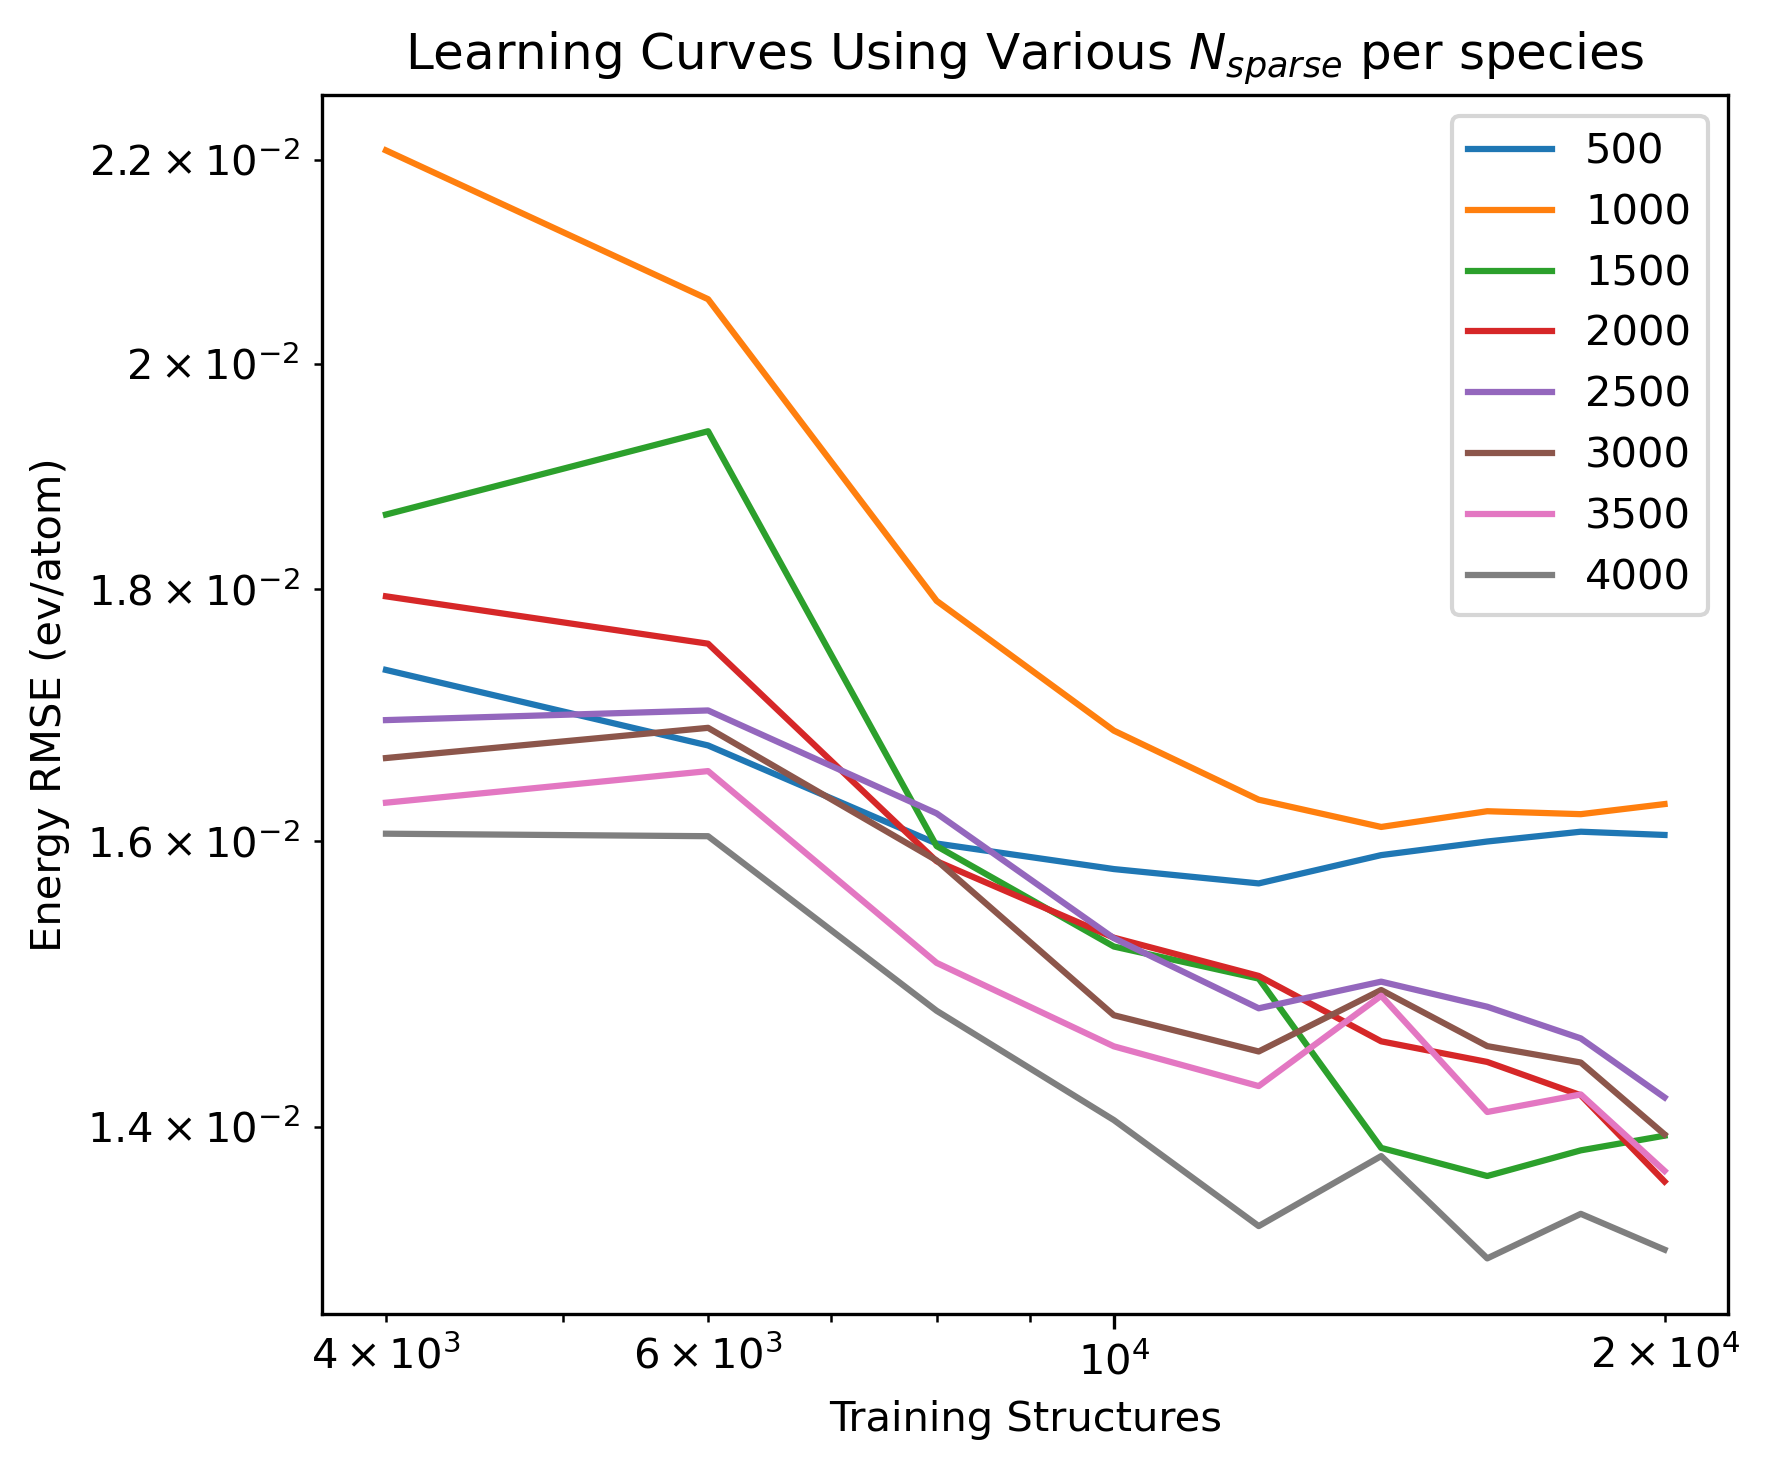

In [17]:
reg=0.02
plt.figure(figsize=(6,5), dpi=300)
for i in range(500, 4001, 500):
    to_plot = np.load(f'learning_curve_data/rmses/{str(reg)}_reg/RMSEs_{str(i)}_sparse_points.npy')
    plt.plot(to_plot[1:, 0], to_plot[1:,1], label=f'{i}')
plt.xscale('log')
plt.xlabel('Training Structures')
plt.yscale('log')
plt.ylabel('Energy RMSE (ev/atom)')
plt.title('Learning Curves Using Various $N_{sparse}$ per species')
plt.legend()
plt.tight_layout()
plt.savefig('figures/learning_curve_n_sparse.png')
plt.savefig('figures/learning_curve_n_sparse.pdf')

Seems like s=500, s=1000 and s=1500 (later on) saturate at before 20000 training points, but the others don't. This likely means that the model is hitting a wall due to the lack of (good) training data, not due to the sparse points. It does, however, suggest that having used 2000 sparse points for your model was a good shout, at least for the training data you have.

**REMEMBER AND MENTION THE FOLLOWING:**
- This was only done using energies, and so model complexity will probably saturate with a greater number of structures when forces are included
- As the structures used are likely to be correlted for the same crystal, the saturation accuracy for all models may be reduced further when using structures from extended simulations

### Get step timings for different N sparse

In [149]:
#Train and test GAP model using various slices of training frames and testing on the first 100 CSD-1k structures
spar_low=500; spar_high=4001; spar_gap=500
ntrain_low=2000; ntrain_high=20001; ntrain_gap=2000
results=np.zeros((len(range(spar_low, spar_high, spar_gap)), 2), dtype=float)

for ni, i in enumerate(range(spar_low, spar_high, spar_gap)):
    K_NM_total = np.load(f'learning_curve_data/Knm_learning_curve_{i}.npy') #import full KNM for this number of sparse points
    X_sparse = load_obj(f'learning_curve_data/X_sparse_PCovFPS_{i}_696.json') #Import X_sparse for this number of sparse points
    
    
    j=2000
    
    K_NM = K_NM_total[:j] #get correct slice of KNM
    print(f"Training GAP model using N_sparse={i} and N_train={j}...")

    model = train_gap_model(kernel, train_frames[:j], K_NM, X_sparse, y_train[:j], y_dressed, 
                            grad_train=None, lambdas=[0.02], jitter=1e-9, solver = 'RKHS') #train model

    #test model on full CSD-1k set (only on first 250 structures)
    npred=250
    start = time()
    ytp = []
    for frm in tqdm(csd_1k[:npred], desc = "Making predictions for test set...", leave=False):
        manager_test = soap.transform(frm)
        ytp.append(model.predict(manager_test))
    
    time_taken = time()-start
    
    print("Time taken:", np.round(time_taken, 6), "s")
    print("")
    results[ni] = [float(i), time_taken]

np.save(f'learning_curve_data/prediction_time_test_n_sparse', results)


Training GAP model using N_sparse=500 and N_train=2000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

Time taken: 42.379735 s

Training GAP model using N_sparse=1000 and N_train=2000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

Time taken: 91.114511 s

Training GAP model using N_sparse=1500 and N_train=2000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

Time taken: 155.36021 s

Training GAP model using N_sparse=2000 and N_train=2000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

Time taken: 202.664025 s

Training GAP model using N_sparse=2500 and N_train=2000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

Time taken: 234.288461 s

Training GAP model using N_sparse=3000 and N_train=2000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

Time taken: 288.775132 s

Training GAP model using N_sparse=3500 and N_train=2000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

Time taken: 336.621913 s

Training GAP model using N_sparse=4000 and N_train=2000...


Making predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

Time taken: 375.142888 s



Text(0.5, 1.0, 'Prediction times')

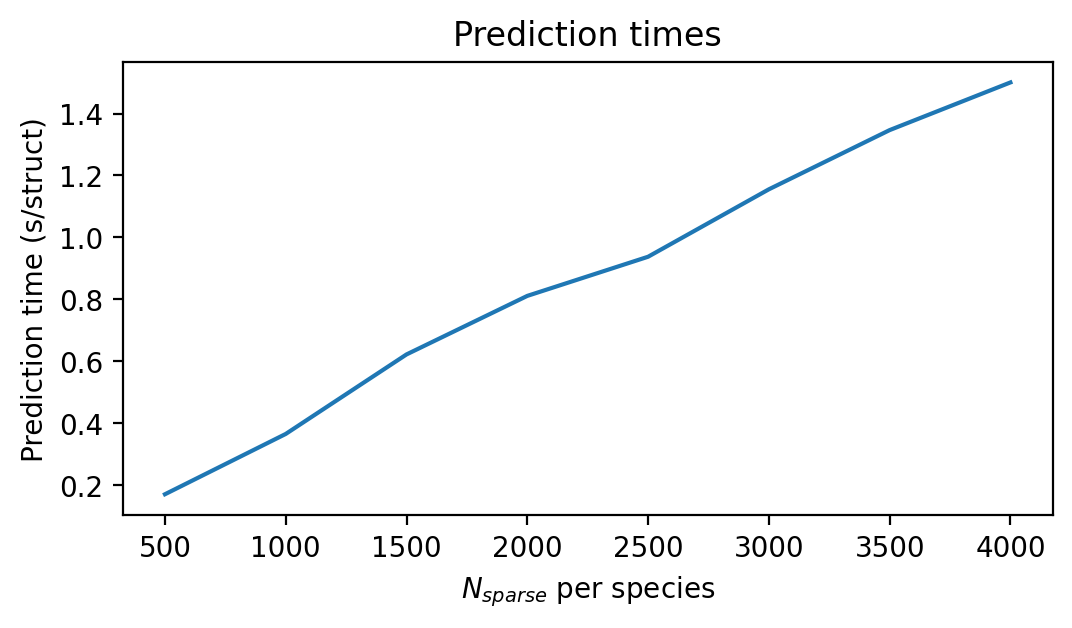

In [205]:
#plot results
plt.figure(figsize=(6,3), dpi=200)
plt.plot(results[:,0], results[:,1]/250)
plt.xlabel('$N_{sparse}$ per species')
plt.ylabel('Prediction time (s/struct)')
plt.title('Prediction times')

In [150]:
#determine time taken to compute the representations
start = time()
for frm in tqdm(csd_1k[:npred], desc = "Computing representations...", leave=False):
    manager_test = soap.transform(frm)
print(f"Time taken to compute the first 250 representations of the test set: \n  {time()-start} s")

Computing representations...:   0%|          | 0/250 [00:00<?, ?it/s]

Time taken to compute the first 250 representations of the test set: 
  7.017690658569336 s


In [151]:
#determine time take to compute representations WITH gradients too
#this will give an idea of what proportion of the predictions will be taken up by computing the representation
#for forces as well
hypers["compute_gradients"] = True
soap = SphericalInvariants(**hypers)

start = time()
for frm in tqdm(csd_1k[:npred], desc = "Computing representations...", leave=False):
    manager_test = soap.transform(frm)
print(f"Time taken to compute the first 250 representations of the test set WITH FORCES: \n  {time()-start} s")

Computing representations...:   0%|          | 0/250 [00:00<?, ?it/s]

Time taken to compute the first 100 representations of the test set WITH FORCES: 
  424.49444484710693 s


For the output here above ^^ this was actually the time taken to compute **250** representations, not 100 (npred was set to 250, just forgot to change the print function)

In [152]:
## Test how long it takes to compute energies cf. forces using an old model (that has the same hypers)
model = load_obj('model_data/full_GAP_model_FPS_0.055_3.25.json')
npred=250
start = time()
ytp = []
ftp = []
for frm in tqdm(csd_1k[:npred], desc = "Making energy predictions for test set...", leave=False):
    manager_test = soap.transform(frm)
    ytp.append(model.predict(manager_test))
time_taken = time()-start
print(f"Time taken to make ONLY ENERGY predictions WITH GRADIENTS: {time_taken}")

start = time()
for frm in tqdm(csd_1k[:npred], desc = "Making energy predictions for test set...", leave=False):
    manager_test = soap.transform(frm)
    ftp.extend(model.predict_forces(manager_test))
time_taken = time()-start
print(f"Time taken to make ONLY FORCE predictions WITH GRADIENTS: {time_taken}")

Making energy predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

Time taken to make ONLY ENERGY predictions WITH GRADIENTS: 571.9197833538055


Making energy predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

Time taken to make ONLY FORCE predictions WITH GRADIENTS: 784.9188103675842


In [156]:
print(f"Time increase in computing forces instead of energies, INCLUDING representations: "
      f"{np.round(784.9188103675842/571.9197833538055, 3)}")

Time increase in computing forces instead of energies, INCLUDING representations: 1.372


In [157]:
print(f"Time increase in computing forces instead of energies, EXCLUDING representations: "
      f"{np.round((784.9188103675842-424.49444484710693)/(571.9197833538055-424.49444484710693), 3)}")

Time increase in computing forces instead of energies, EXCLUDING representations: 2.445


In [164]:
print(f" Number of sparse points per species for this model: {len(model.get_weights())/4}")

 Number of sparse points per species for this model: 1622.5


In [168]:
print(f"Time taken to make only energy predictions (excluding representation w/ gradients computation time)"
     f" using {len(model.get_weights())/4} sparse points per species: {np.round((571.9197-424.4944), 5)}")

Time taken to make only energy predictions (excluding representation w/ gradients computation time) using 1622.5 sparse points per species: 147.4253


The above result makes sense, as only slightly more sparse points per species were used than for the N Sparse = 1500 model trained on only energies, and that model had a prediction time of 155s (including the 7s required for computing representations without gradients). Discrepancy may be due to the use of a different number of sparse points for different species...

**Results:**
- Computing the representation without energies took only around 7.02 seconds for all 250 points, and so increasing the number of sparse points is the primary driver or the increased prediction time experienced
- The dependency of the number of sparse points on prediction time is the same for a model with or without forces used for training
- However, the amount of time taken to compute just the representation with gradients increases by a factor of about 60, whereas the energy prediction time stays more or less constant
- This means that the proportion of time taken to compute the representation will be far larger when gradients are included (as we already knew), and so the benefit of using a larger number of training structures will be greater when forces are used in training as well

In [19]:
## Test how long it takes to compute energies cf. forces using an old model (that has the same hypers)
model = load_obj('model_data/full_GAP_model_FPS_0.055_3.25.json')

In [21]:
hypers["compute_gradients"] = True
soap = SphericalInvariants(**hypers)

In [23]:
npred=250
start = time()
ytp = []
ftp = []
for frm in tqdm(csd_1k[:npred], desc = "Making energy and force predictions for test set...", leave=False):
    manager_test = soap.transform(frm)
    ytp.append(model.predict(manager_test))
    ftp.extend(model.predict_forces(manager_test))
time_taken = time()-start
print(f"Time taken to make ENERGY AND FORCE predictions WITH GRADIENTS: {time_taken}")

Making energy and force predictions for test set...:   0%|          | 0/250 [00:00<?, ?it/s]

Time taken to make ENERGY AND FORCE predictions WITH GRADIENTS: 971.5557570457458
